## Toxic Comment Classification using Conv1D

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-08 02:25:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-08 02:25:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-08 02:25:16--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
!unzip jigsaw-toxic-comment-classification-challenge.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: test_labels.csv         
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [0]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (Dense,Input,GlobalMaxPooling1D,
                          Conv1D,MaxPooling1D,Embedding,Dropout)
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [0]:
# config variables
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [7]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
  print('Found %s word vectors.'%len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [8]:
# prepare text samples and their labels
print('Loading in comments...')
train = pd.read_csv('train.csv')
sentences = train['comment_text'].values
possible_labels = ['toxic','severe_toxic','obscene',
                   'threat','insult','identity_hate']
targets = train[possible_labels].values

Loading in comments...


In [9]:
s = sorted(len(s) for s in sentences)
print('max seq length:',max(s))
print('min seq length:',min(s))
print('median seq length:',s[len(s)//2])

max seq length: 5000
min seq length: 6
median seq length: 205


In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.'%len(word2idx))

Found 210337 unique tokens.


In [12]:
# pad sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:',data.shape)

Shape of data tensor: (159571, 100)


In [14]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [0]:
# loading pre-trained word embeddings into an Embedding Layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [29]:
# building the model
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

W0808 04:18:49.437323 140705306535808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [31]:
print('Training model..')
r = model.fit(data, targets, batch_size=BATCH_SIZE,
              epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Training model..
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 12s 97us/step - loss: 0.0988 - acc: 0.9700 - val_loss: 0.0884 - val_acc: 0.9750
Epoch 2/10
127656/127656 [==============================] - 12s 92us/step - loss: 0.0802 - acc: 0.9747 - val_loss: 0.0748 - val_acc: 0.9744
Epoch 3/10
127656/127656 [==============================] - 12s 92us/step - loss: 0.0775 - acc: 0.9752 - val_loss: 0.0826 - val_acc: 0.9765
Epoch 4/10
127656/127656 [==============================] - 12s 92us/step - loss: 0.0775 - acc: 0.9754 - val_loss: 0.0874 - val_acc: 0.9759
Epoch 5/10
127656/127656 [==============================] - 12s 92us/step - loss: 0.0776 - acc: 0.9755 - val_loss: 0.0750 - val_acc: 0.9767
Epoch 6/10
127656/127656 [==============================] - 12s 92us/step - loss: 0.0788 - acc: 0.9755 - val_loss: 0.0736 - val_acc: 0.9761
Epoch 7/10
127656/127656 [==============================] - 12s 92us/step - loss: 0.0810 - a

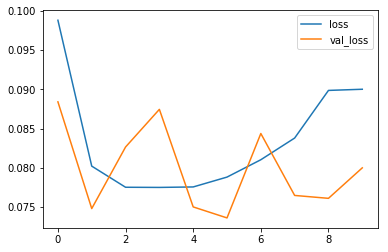

In [32]:
# plot the results
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

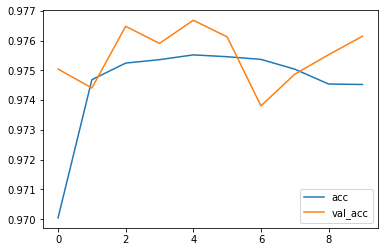

In [33]:
# accuracies
plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [34]:
p=model.predict(data)
aucs=[]
for j in range(6):
  auc = roc_auc_score(targets[:,j], p[:,j])
  aucs.append(auc)
print(np.mean(aucs))

0.949491464294686
